In [57]:
#importing packages 
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
from calendar import monthrange
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import math 

In the analytical part of the projiect I was aimning to derive market expectaions for the future fed funds rate based on futures prices



Analytic resourses 

1. https://www.federalreserve.gov/econres/notes/feds-notes/new-way-to-visualize-the-evolution-of-monetary-policy-expectations-20190920.html

2. https://www.atlantafed.org/cenfis/publications/notesfromthevault/1608

3. https://www.frbsf.org/education/publications/doctor-econ/2003/march/interest-rate-forecasts/


Donwloading and cleaning data 

In [36]:

df = pd.read_csv('FFR_rates_futures.csv') 
df = df[["Day", "Rate", "PriceNextDay", "PricePrevDay", "PriceDifference", "RateDifference"]] #select only usefull cols 
df = df.drop(range(100,107)) # dropping rows with absent values (no futures data)

In [37]:
df['Day'] = df['Day'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) # convert day to datetime format

In [38]:

#determing month type 
#To calculate unconditional probability of a change in the target at the current month FOMC meeting, 
# the primary consideration is whether there is an FOMC meeting in the month immediately before “meeting” month. 
# If there was no meeting in the month prior, it is categorized as a “Type 2 meeting." 
# Otherwise, it is categorized as a “Type 1 meeting." To see this, consider the following table:

returnlist = []
for i in range(len(df['Day'])):
    if i == len(df['Day']) - 1:
        returnlist.append(1)
    else:
        value = (df['Day'][i].month - df['Day'][i+1].month)%12
        if value <= 1:
            returnlist.append(1)
        else:
            returnlist.append(2)
df['MonthType'] = pd.Series(returnlist)

In [39]:
df['N'] = df['Day'].apply(lambda x: monthrange(x.year, x.month)[1]) #Days in Meeting Month	
df['M'] = df['Day'].apply(lambda x: x.day -1)                       # Day(MeetingDate) – 1
df['ImpliedRate'] = df['PricePrevDay'].apply(lambda x: 100 -x)      #100 – FF.MeetingMonth

In [40]:
df

,Day,Rate,PriceNextDay,PricePrevDay,PriceDifference,RateDifference,MonthType,N,M,ImpliedRate
0,2022-11-02,3.875,96.214996,96.214996,0.000000,0.75,2,30,1,3.785004
1,2022-09-21,3.125,97.442497,97.432503,0.009995,0.75,2,30,20,2.567497
2,2022-07-27,2.375,98.324997,98.317497,0.007500,0.75,1,31,26,1.682503
3,2022-06-15,1.625,98.792503,98.809998,-0.017494,0.75,1,30,14,1.190002
4,2022-05-04,0.875,99.230003,99.217499,0.012505,0.50,2,31,3,0.782501
...,...,...,...,...,...,...,...,...,...,...
95,2001-04-18,4.500,95.184998,95.014999,0.169998,-0.50,1,30,17,4.985001
96,2001-03-20,5.000,94.714996,94.735001,-0.020004,-0.50,2,31,19,5.264999
97,2001-01-31,5.500,94.540001,94.019997,0.520004,-0.50,1,31,30,5.980003
98,2001-01-03,6.000,93.989998,93.550003,0.439995,-0.50,1,31,2,6.449997


In [41]:
def averageoverspan(datetime1, datetime2, price_dict):
    change_dt = datetime1
    total = 0
    count = 0
    while change_dt < datetime2:
        change_str = datetime.strftime(change_dt, "%Y-%m-%d")
        if change_str in price_dict:
            total += price_dict[change_str]
            count +=1
        change_dt += timedelta(1)
    return total/count

In [42]:
with open('priceoffutures_dict.json') as json_file:
    priceoffutures_dict = json.load(json_file)

In [43]:
returnlist = []

for i in range(len(df['Day'])):
    ##print(df['Day'][i], type(df['Day'][i]))
    end_dt = df['Day'][i].replace(day=1) - timedelta(1)
    beginning_dt = end_dt.replace(day=1)
    returnlist.append(100 - averageoverspan(beginning_dt, end_dt, priceoffutures_dict))

df['FFER.Start'] = pd.Series(returnlist)

In [71]:
#test

end_dt = df['Day'][10].replace(day=1) - timedelta(1)
beginning_dt = end_dt.replace(day=1)
#print('day', df['Day'][10], '\nfirst day of the month', df['Day'][10].replace(day = 1), '\nthe day befothe first day of current month', df['Day'][10].replace(day=1) - timedelta(1),   '\nfirst day of prev month', beginning_dt)

print('day', df['Day'][10], '\nstartdt', beginning_dt, '\nenddt',end_dt)
print((100 - averageoverspan(beginning_dt, end_dt, priceoffutures_dict)))



day 2020-06-10 00:00:00 
startdt 2020-05-01 00:00:00 
enddt 2020-05-31 00:00:00
0.05087509155274006


In [44]:
returnlist = []

for i in range(len(df['Day'])):
    N = df['N'][i]
    M = df['M'][i]
    
    value= N/(N-M) * (df['ImpliedRate'][i]- (M/N)*df['FFER.Start'][i])
    
    returnlist.append(value)

df['FFER.End'] = pd.Series(returnlist)

In [45]:
P_Hikelist = []
P_NoHikelist = []
for i in range(len(df['FFER.Start'])):
    value = (df['FFER.End'][i] - df['FFER.Start'][i])/.25
    P_Hikelist.append(value)
df['P_Hike'] = pd.Series(P_Hikelist)

In [46]:
df

,Day,Rate,PriceNextDay,PricePrevDay,PriceDifference,RateDifference,MonthType,N,M,ImpliedRate,FFER.Start,FFER.End,P_Hike
0,2022-11-02,3.875,96.214996,96.214996,0.000000,0.75,2,30,1,3.785004,3.082247,3.809237,2.907958
1,2022-09-21,3.125,97.442497,97.432503,0.009995,0.75,2,30,20,2.567497,2.334203,3.034087,2.799537
2,2022-07-27,2.375,98.324997,98.317497,0.007500,0.75,1,31,26,1.682503,1.141308,4.496715,13.421629
3,2022-06-15,1.625,98.792503,98.809998,-0.017494,0.75,1,30,14,1.190002,0.745875,1.578614,3.330955
4,2022-05-04,0.875,99.230003,99.217499,0.012505,0.50,2,31,3,0.782501,0.328674,0.831126,2.009805
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2001-04-18,4.500,95.184998,95.014999,0.169998,-0.50,1,30,17,4.985001,5.286501,4.590730,-2.783083
96,2001-03-20,5.000,94.714996,94.735001,-0.020004,-0.50,2,31,19,5.264999,5.477224,4.928978,-2.192985
97,2001-01-31,5.500,94.540001,94.019997,0.520004,-0.50,1,31,30,5.980003,6.473422,-8.822544,-61.183862
98,2001-01-03,6.000,93.989998,93.550003,0.439995,-0.50,1,31,2,6.449997,6.473422,6.448381,-0.100161


In [59]:
#df['P_Hike_Normalized_Index'] = (df['P_Hike'] - np.mean(df['P_Hike'])) / np.std(df['P_Hike'])
#df['Rate_Change_Normalized'] = (df['RateDifference'] - np.mean(df['RateDifference'])) / np.std(df['RateDifference'])
#df['Shock_Index'] = abs(df['P_Hike_Normalized_Index'] - df['Rate_Change_Normalized'])

In [47]:
a_df = df[["Day", "Rate",  "RateDifference", "P_Hike"]]

In [30]:
df['ImpliedHike'] = df["P_Hike"] * 0.25
df['Factual_V_Implied'] = df["RateDifference"] - df["ImpliedHike"]

In [48]:
a_df

,Day,Rate,RateDifference,P_Hike
0,2022-11-02,3.875,0.75,2.907958
1,2022-09-21,3.125,0.75,2.799537
2,2022-07-27,2.375,0.75,13.421629
3,2022-06-15,1.625,0.75,3.330955
4,2022-05-04,0.875,0.50,2.009805
...,...,...,...,...
95,2001-04-18,4.500,-0.50,-2.783083
96,2001-03-20,5.000,-0.50,-2.192985
97,2001-01-31,5.500,-0.50,-61.183862
98,2001-01-03,6.000,-0.50,-0.100161


In [68]:
# ~ decidion tree (does not account for 'nochange' scenarios')
# if implied probability of a hike is over 100% we are assuming that the markets are impying a bigger hike
# if P_hike = 2.907958 we assume that the hike if going to either be 0.5 or 0.75 because 2.9 * 0.25 is in (0.5, 0.75)

def B_tree(P_hike):
    res = {}
    P_max_hike = abs(math.ceil(P_hike) - P_hike)
    res[math.ceil(P_hike) * 0.25] = P_max_hike
    res[math.floor(P_hike) * 0.25] = 1 - P_max_hike 
    return res
            
               
val = 2.907958          
B_tree(val)

{0.75: 0.09204200000000018, 0.5: 0.9079579999999998}

In [66]:
df['B_tree'] = df["P_Hike"].apply(lambda x: B_tree(x))
df

,Day,Rate,PriceNextDay,PricePrevDay,PriceDifference,RateDifference,MonthType,N,M,ImpliedRate,FFER.Start,FFER.End,P_Hike,B_tree
0,2022-11-02,3.875,96.214996,96.214996,0.000000,0.75,2,30,1,3.785004,3.082247,3.809237,2.907958,"{0.75: 0.09204206795530112, 0.5: 0.90795793204..."
1,2022-09-21,3.125,97.442497,97.432503,0.009995,0.75,2,30,20,2.567497,2.334203,3.034087,2.799537,"{0.75: 0.20046303489016104, 0.5: 0.79953696510..."
2,2022-07-27,2.375,98.324997,98.317497,0.007500,0.75,1,31,26,1.682503,1.141308,4.496715,13.421629,"{3.5: 0.5783705938427381, 3.25: 0.421629406157..."
3,2022-06-15,1.625,98.792503,98.809998,-0.017494,0.75,1,30,14,1.190002,0.745875,1.578614,3.330955,"{1.0: 0.6690454483033079, 0.75: 0.330954551696..."
4,2022-05-04,0.875,99.230003,99.217499,0.012505,0.50,2,31,3,0.782501,0.328674,0.831126,2.009805,"{0.75: 0.990195138113839, 0.5: 0.0098048618861..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2001-04-18,4.500,95.184998,95.014999,0.169998,-0.50,1,30,17,4.985001,5.286501,4.590730,-2.783083,"{-0.5: 0.7830834021935651, -0.75: 0.2169165978..."
96,2001-03-20,5.000,94.714996,94.735001,-0.020004,-0.50,2,31,19,5.264999,5.477224,4.928978,-2.192985,"{-0.5: 0.19298468695741633, -0.75: 0.807015313..."
97,2001-01-31,5.500,94.540001,94.019997,0.520004,-0.50,1,31,30,5.980003,6.473422,-8.822544,-61.183862,"{-15.25: 0.18386198345029214, -15.5: 0.8161380..."
98,2001-01-03,6.000,93.989998,93.550003,0.439995,-0.50,1,31,2,6.449997,6.473422,6.448381,-0.100161,"{0.0: 0.10016057452355298, -0.25: 0.8998394254..."


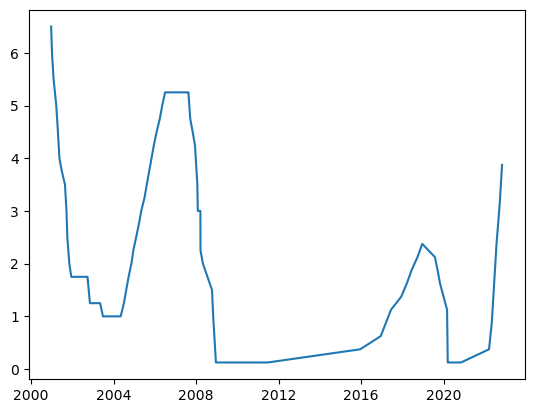

In [74]:
plt.plot(test.Day, test.Rate)

<AxesSubplot:xlabel='Day', ylabel='Rate'>

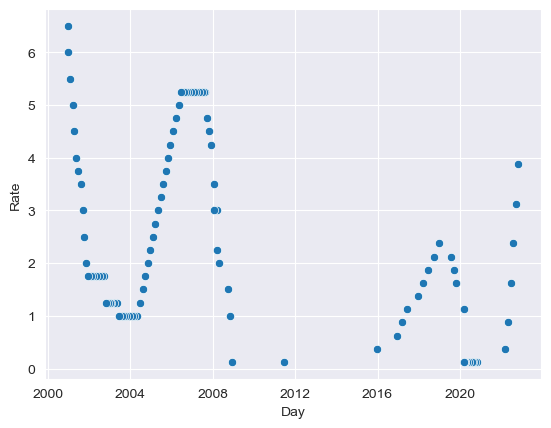

In [86]:
sns.scatterplot(x='Day', y='Rate', data=test)


<AxesSubplot:xlabel='RateDifference', ylabel='Factual_V_Implied'>

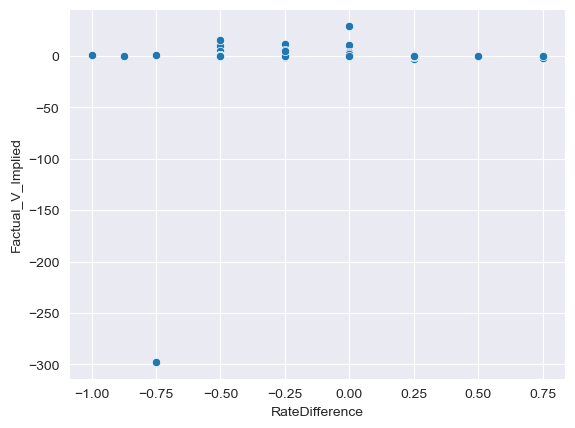

In [85]:
sns.scatterplot(x='RateDifference', y='Factual_V_Implied', data=test)